## Normal Run

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nlm_synth.monte_carlo import run_experiments
from nlm_synth.visualize import plot_metric_by_scale

In [16]:
#synthetic bi-modal NDVI mixture (demo)
rng = np.random.default_rng(123)
veg = rng.normal(0.7, 0.08, size=50_000)
soil = rng.normal(0.2, 0.09, size=30_000)
samples = np.clip(np.hstack([veg, soil]), -0.2, 1.0)

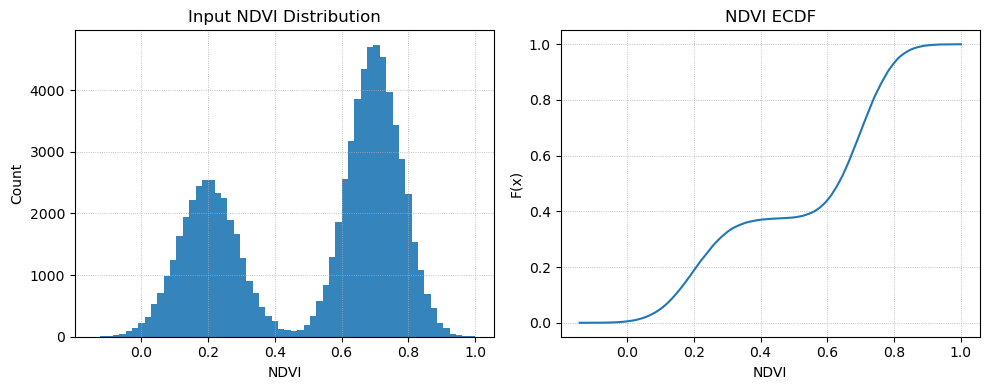

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histogram (marginal NDVI)
ax[0].hist(samples, bins=60, edgecolor='none', alpha=0.9)
ax[0].set_title('Input NDVI Distribution')
ax[0].set_xlabel('NDVI')
ax[0].set_ylabel('Count')
ax[0].grid(True, ls=':', lw=0.6)

# ECDF
srt = np.sort(samples)
y = np.linspace(0, 1, len(srt), endpoint=False)
ax[1].plot(srt, y, lw=1.5)
ax[1].set_title('NDVI ECDF')
ax[1].set_xlabel('NDVI')
ax[1].set_ylabel('F(x)')
ax[1].grid(True, ls=':', lw=0.6)

plt.tight_layout()
plt.show()

In [18]:
generator_grid = [
    {'label': 'perlin_LF', 'method': 'perlin',
     'method_kwargs': dict(periods=(2,2), octaves=3, lacunarity=2, persistence=0.7)},
    {'label': 'perlin_MF', 'method': 'perlin',
     'method_kwargs': dict(periods=(4,4), octaves=5, lacunarity=2, persistence=0.6)},
    {'label': 'perlin_HF', 'method': 'perlin',
     'method_kwargs': dict(periods=(8,8), octaves=6, lacunarity=2, persistence=0.5)},
    {'label': 'cluster_nn', 'method': 'cluster',
     'method_kwargs': dict(p=0.55, nn_prob=0.65, periods=(6,6), octaves=2, lacunarity=2, persistence=0.4)},
]

df, meta = run_experiments(samples,
                           nrow=512, ncol=512,
                           generator_grid=generator_grid,
                           coarsen_factors=(1,2,4,8,16,32),
                           n_runs=10, semivar=False, random_seed=44)

In [19]:
df.to_csv('results_mc.csv', index=False)
print('Saved results to results_mc.csv')
print(df.head())

Saved results to results_mc.csv
       mean  variance   std_dev  morans_I       n  shape_r  shape_c  run  \
0  0.481281  0.046372  0.215341  0.999792  262144      512      512    0   
1  0.481281  0.046345  0.215279  0.998756   65536      256      256    0   
2  0.481281  0.046254  0.215067  0.994857   16384      128      128    0   
3  0.481281  0.045959  0.214381  0.981796    4096       64       64    0   
4  0.481281  0.045009  0.212154  0.942993    1024       32       32    0   

       label  method  factor  pixel_size_rel  
0  perlin_LF  perlin       1             1.0  
1  perlin_LF  perlin       2             2.0  
2  perlin_LF  perlin       4             4.0  
3  perlin_LF  perlin       8             8.0  
4  perlin_LF  perlin      16            16.0  


In [20]:
from nlm_synth.generators import perlin_field, rank_map_to_distribution

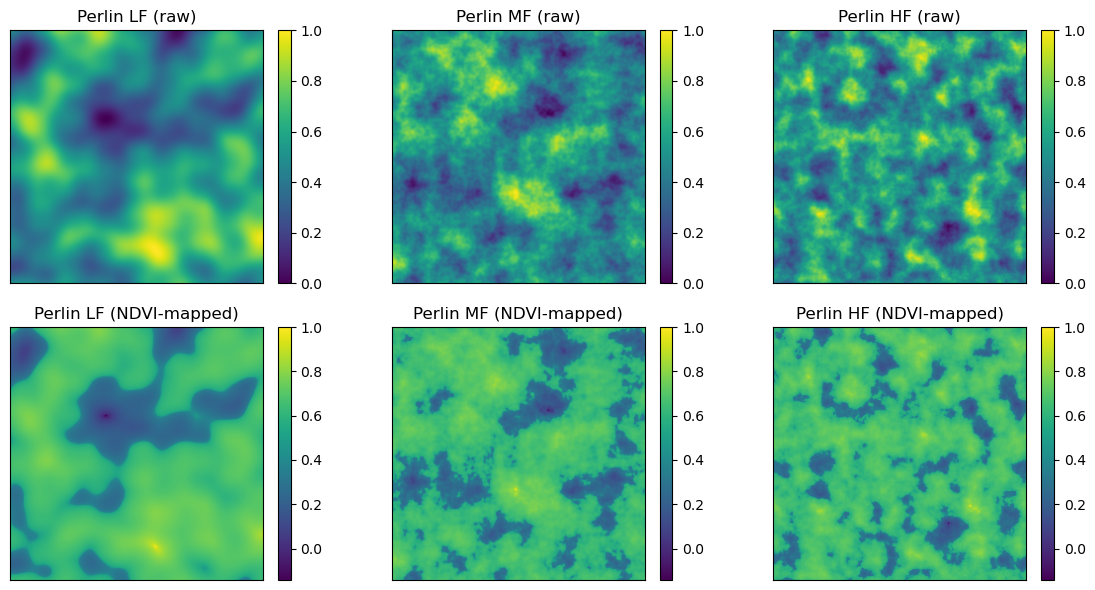

In [26]:
vis_n = 256  # smaller view for quick plotting
perlin_cfgs = [
    ('Perlin LF', dict(periods=(2,2),  octaves=3, lacunarity=2, persistence=0.7, seed=1)),
    ('Perlin MF', dict(periods=(4,4),  octaves=5, lacunarity=2, persistence=0.6, seed=2)),
    ('Perlin HF', dict(periods=(8,8),  octaves=6, lacunarity=2, persistence=0.5, seed=3)),
]

# Build figure: top row = raw Perlin (0..1), bottom row = NDVI-mapped via rank mapping
fig, axes = plt.subplots(2, len(perlin_cfgs), figsize=(4*len(perlin_cfgs), 6))

for j, (title, kwargs) in enumerate(perlin_cfgs):
    fld01 = perlin_field(vis_n, vis_n, **kwargs)  # raw 0..1 field
    mapped = rank_map_to_distribution(fld01, samples)  # NDVI-mapped

    im0 = axes[0, j].imshow(fld01, origin='upper')
    axes[0, j].set_title(f'{title} (raw)')
    axes[0, j].set_xticks([]); axes[0, j].set_yticks([])
    fig.colorbar(im0, ax=axes[0, j], fraction=0.046, pad=0.04)

    im1 = axes[1, j].imshow(mapped, origin='upper')
    axes[1, j].set_title(f'{title} (NDVI-mapped)')
    axes[1, j].set_xticks([]); axes[1, j].set_yticks([])
    fig.colorbar(im1, ax=axes[1, j], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

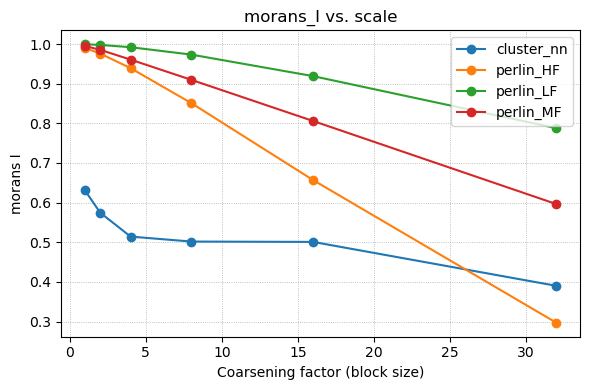

In [22]:
plot_metric_by_scale(df, metric='morans_I', by='label')
plt.savefig('moransI_vs_scale.png', dpi=150)

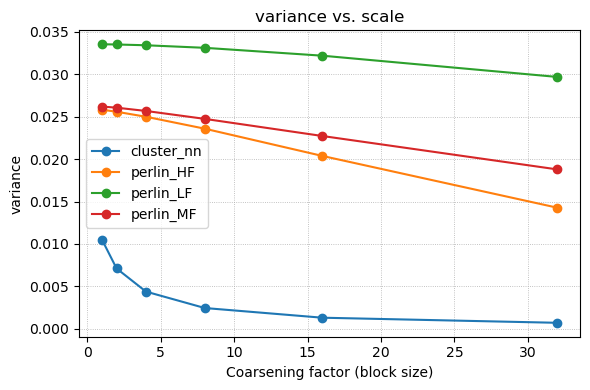

In [23]:
plot_metric_by_scale(df, metric='variance', by='label')
plt.savefig('variance_vs_scale.png', dpi=150)

## Xarray Run

In [27]:
import numpy as np
import pandas as pd
import pathlib
import sys
import importlib.util

from nlm_synth.xarray_mc import run_experiments_geotiff


In [ ]:
etp_path = pathlib.Path('ETparams.py')  # e.g., Path('/absolute/path/ETparams.py')
if not etp_path.exists():
    raise FileNotFoundError(f"Could not find {etp_path.resolve()}")

spec = importlib.util.spec_from_file_location('ETparams', etp_path)
ETparams = importlib.util.module_from_spec(spec)
sys.modules['ETparams'] = ETparams
spec.loader.exec_module(ETparams)

# Create NDVI parameter and sample distribution
ndvi_param = ETparams.MixtureETParameter(
    name="NDVI",
    mu1_bounds=(0.1, 0.5),
    mu2_bounds=(0.5, 0.9),
    w1_bounds=(0.2, 0.8),
    sigma1_bounds=(0.02, 0.05),
    sigma2_bounds=(0.02, 0.05),
)

In [29]:
# Latin Hypercube to pick a parameter set (1 draw per MC run here)
ndvi_param.lhs_sample(N_samples=1)

# Choose NDVI marginal flavor: 'mixture' or 'normal'
dist_type = 'mixture'   # switch to 'normal' to compare unimodal approx
ndvi_dist = ndvi_param.create_dist(dist_type=dist_type)

# Draw many samples to define the marginal for rank-mapping
samples = np.clip(ndvi_dist.sample(100_000), -0.2, 1.0)

In [30]:
# ---------------------------------------------------------------------
# (B) Georeferencing settings: CRS, transform origin, pixel size
# ---------------------------------------------------------------------
# Option 1: define transform from origin + pixel size (north-up)
x0, y0 = 500_000.0, 4_000_000.0   # upper-left corner in projected coords
pixel_size = 30.0                 # meters
crs = "EPSG:32611"

In [ ]:
# Option 2 (optional): derive CRS/transform from a template GeoTIFF
# import rioxarray as rxr
# tpl = rxr.open_rasterio('template.tif').squeeze()
# crs = tpl.rio.crs.to_string()
# pixel_size = tpl.rio.resolution()[0]  # assumes square pixels
# x0 = tpl.rio.transform().c
# y0 = tpl.rio.transform().f


In [31]:
# ---------------------------------------------------------------------
# (C) Run Monte Carlo with GeoTIFF outputs
# ---------------------------------------------------------------------
out_dir = 'ndvi_mc_geotiff'
df, meta = run_experiments_geotiff(
    samples=samples,
    out_dir=out_dir,
    nrow=512, ncol=512,
    pixel_size=pixel_size,
    x0=x0, y0=y0,
    crs=crs,
    generator_grid=[
        {'label': 'perlin_LF', 'method': 'perlin',
         'method_kwargs': dict(periods=(2,2), octaves=3, lacunarity=2, persistence=0.7)},
        {'label': 'perlin_HF', 'method': 'perlin',
         'method_kwargs': dict(periods=(8,8), octaves=6, lacunarity=2, persistence=0.5)},
        {'label': 'cluster_nn', 'method': 'cluster',
         'method_kwargs': dict(p=0.55, nn_prob=0.65, periods=(6,6), octaves=2, lacunarity=2, persistence=0.4)},
    ],
    coarsen_factors=(1,2,4,8,16,32),
    n_runs=5,
    random_seed=123,
    write_fullres=True,
    name_prefix=f'ndvi_{dist_type}',
)

print('Saved GeoTIFFs/results to:', out_dir)
print(df.head())

Saved GeoTIFFs/results to: ndvi_mc_geotiff
      mean  variance   std_dev  morans_I       n  shape_r  shape_c  run  \
0  0.44765  0.001891  0.043480  1.000456  262144      512      512    0   
1  0.44765  0.001890  0.043474  1.000370   65536      256      256    0   
2  0.44765  0.001888  0.043449  0.998604   16384      128      128    0   
3  0.44765  0.001879  0.043353  0.989137    4096       64       64    0   
4  0.44765  0.001848  0.042984  0.951728    1024       32       32    0   

       label  method  factor  pixel_size  nrow  ncol  
0  perlin_LF  perlin       1        30.0   512   512  
1  perlin_LF  perlin       2        60.0   256   256  
2  perlin_LF  perlin       4       120.0   128   128  
3  perlin_LF  perlin       8       240.0    64    64  
4  perlin_LF  perlin      16       480.0    32    32  
